In [204]:
import numpy as np
from numpy import genfromtxt
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import normalized_mutual_info_score
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from scipy.stats import norm
from scipy.integrate import quad
from sklearn.manifold import TSNE

# Question 1

In [2]:
A = genfromtxt('life_expectancy_X.csv', delimiter=',')
A_test = genfromtxt('life_expectancy_X_test.csv', delimiter=',')

y = genfromtxt('life_expectancy_y.csv', delimiter=',')
y_test = genfromtxt('life_expectancy_y_test.csv', delimiter=',')

# Scale
scaler = MinMaxScaler()
A = scaler.fit_transform(A)
A_test = scaler.transform(A_test)

### 1)

In [3]:
def f_prime(w, phi, y, l1_lambda):
    return (1/len(phi))*(phi.T @ (phi@w - y)) + l1_lambda * np.sign(w)

def gradient_descent(phi, y, w, eta, num_iterations, l1_lambda):
	for i in range(num_iterations):
		w = w - eta * f_prime(w, phi, y, l1_lambda)  
            
	return w

def mse_func(phi, w, y):
	return np.mean((phi@w - y)**2)

def sorted_features_importance(feature_names_list, w, lin_reg=False):
	if lin_reg == True:
		sorted_w = w[:-1]
	else:
		sorted_w = w

	sorted_indices = np.argsort(-np.abs(sorted_w))
	sorted_features = [feature_names_list[i] for i in sorted_indices]
	sorted_w = w[sorted_indices]

	for feature, weight in zip(sorted_features, sorted_w):
		print(f"{feature}: {weight:.4f}")

In [4]:
phi = np.hstack((np.ones((A.shape[0], 1)), A))
w0 = np.zeros(phi.shape[1])
eta = 0.02
l1_lambda = 0.01

w = gradient_descent(phi, y, w0, eta, 10000, l1_lambda)

phi_test = np.hstack((np.ones((A_test.shape[0], 1)), A_test))

print(f'MSE: {mse_func(phi_test, w, y_test)}')

MSE: 0.005947909788639809


### 2)

In [5]:
feature_names = [
    "Exercise amount",
    "Amount of supportive relationships",
    "Number of siblings",
    "Alcohol / Drugs / Smoking consumption",
    "Height",
    "Attractiveness",
    "work ethics"
]

sorted_features_importance(feature_names, w, lin_reg=True)

Exercise amount: 59.8926
Amount of supportive relationships: 29.9769
Number of siblings: 14.9417
Height: -9.8219
Attractiveness: 0.0002
Alcohol / Drugs / Smoking consumption: 0.0001
work ethics: -0.0000


Biggest Positive Impact: Exercise Amount, Supportive Relationshops, Number of Siblings  
Negative Impact: Height  
Attractiveness, Alcohol/Drugs/Smoking, and Work Ethic all have a minimal impact on longetivty  

### 3)

In [6]:
def center_func(n):
      C = np.eye(n) - (1/n) * np.ones((n, n))
      return C

def pca_reduc_func(X, num_dimensions):
    n = len(X)

    C = center_func(n)
    Q = X.T @ C @ X

    [D, V] = np.linalg.eigh(Q)

    v = V[:, -num_dimensions:]

    X_hat = X @ v 

    return X_hat, v, D 

def f_prime(w, phi, y):
    return (1/len(phi))*(phi.T @ (phi@w - y))

def gradient_descent(phi, y, w, eta, num_iterations):
    for i in range(num_iterations):
        w = w - eta * f_prime(w, phi, y)  

    return w

In [14]:
pca_A, pca_v, eig_vals = pca_reduc_func(A, 4)

pca_phi = np.hstack((np.ones((pca_A.shape[0], 1)), pca_A))
w0 = np.zeros(pca_phi.shape[1])
eta = 0.05

pca_w = gradient_descent(pca_phi, y, w0, eta, 20000)

A_test_C = center_func(len(A_test))
pca_A_test = A_test @ pca_v

pca_phi_test = np.hstack((np.ones((pca_A_test.shape[0], 1)), pca_A_test))
print(f'Test MSE: {mse_func(pca_phi_test, pca_w, y_test)}')
# print(f'MSE: {mse_func(pca_phi, pca_w, y)}')

Test MSE: 58.21643737770854


In [31]:
feature_contributions = np.mean(pca_v, axis=1)
feature_contributions

array([ 0.09306744,  0.2454878 , -0.25985832,  0.05647923, -0.18328759,
       -0.27576156, -0.02681717])

### 4)
PCA probably is not a good idea for this problem as shown by the much higher MSE than regular LASSO Linear Regression. PCA tries to maximize variance but does not account for the labels. Therefore, features which have low variance but high importance for predicting longetivity will have their importance reduce when PCA is applied. For example, number of sibilings and also relationships probably have a low variance but are of high importance to predicting longetivity, so with PCA their importance would be reduced. Therefore, using linear regression is not a good predictor for this problem and should not be used.

In [34]:
def cov_func(X, Y):
    n = len(X)
    x_mean = np.mean(X)
    y_mean = np.mean(Y)

    return (1/n) * sum((X[i] - x_mean)*(Y[i] - y_mean) for i in range(n))


def corr_func(X, Y):
    return (cov_func(X, Y))/(np.sqrt((cov_func(X, X))*(cov_func(Y, Y))))

corr_list = []
for xi in A.T:
    corr = corr_func(xi, y)
    corr_list.append(corr)

print(corr_list)

[0.8508629239616721, 0.43643566943179135, 0.002459752414860447, -0.3122734519911499, -0.036254143816136813, -0.03482415007593405, 0.03136403248523949]


In [35]:
# Check correlations with feature names
feature_names = [
    "Exercise amount",
    "Amount of supportive relationships",
    "Number of siblings",
    "Alcohol / Drugs / Smoking consumption",
    "Height",
    "Attractiveness",
    "work ethics"
]

sorted_features_importance(feature_names, np.array(corr_list))

Exercise amount: 0.8509
Amount of supportive relationships: 0.4364
Alcohol / Drugs / Smoking consumption: -0.3123
Height: -0.0363
Attractiveness: -0.0348
work ethics: 0.0314
Number of siblings: 0.0025


Exercise amount and supportive relationships have a significant positive correlation with longetivty.  
Alcohol/drugs has a fairly siginificant negative correlation with longetivty.  
Height, attractivness, work ethics, and number of siblings have a minimal correlation with longeivity.

### 6)

Both excericise amount and amount of supportive relationshops have a big postitive impact according to correlation and the LASSO weights. However, Alcohol/drugs consumption has a decently high negative correlation, while the LASSO weight is basically zero. Furthermore, according to the weights, number of siblings is the third most important feature, but it has a very low correlation.

In [ ]:
# Use eigenvalues to find most impactful features for PCA
eig_features = np.mean(np.abs(pca_v), axis=1)

sorted_features_importance(feature_names, eig_features)

Alcohol / Drugs / Smoking consumption: 0.3101
Attractiveness: 0.3002
Number of siblings: 0.2965
Amount of supportive relationships: 0.2455
work ethics: 0.2313
Height: 0.2184
Exercise amount: 0.1348


For PCA, the order of impactfulness is: alcohol consumption, attractiveness, number of siblings, amount of relationships, work ethic, height, and finally exercise amount. This is the opposite of correlation and LASSO weights, as exercise is the most impactful feature according to those metrics. Attractiveness is also low for both of those metrics, while attractiveness has the second biggest impact on PCA. Alcohol consumption has a somewhat high negative correlation, and is also the most impactful PCA feature. Overall, the correlation table matches the LASSO weights more than the PCA feature importance.

# Question 2

In [3]:
A = genfromtxt('gpa_prediction_X.csv', delimiter=',')
A_test = genfromtxt('gpa_prediction_X_test.csv', delimiter=',')

y = genfromtxt('gpa_prediction_y.csv', delimiter=',')
y_test = genfromtxt('gpa_prediction_y_test.csv', delimiter=',')

# Scale
scaler = MinMaxScaler()
A = scaler.fit_transform(A)
A_test = scaler.transform(A_test)

### 1)

In [ ]:
def accuracy_func(predictions, y):
    return np.mean(predictions == y)

# Logistic Regression
def f_prime(w, phi, y, l1_lambda):
    return 1/len(phi) * phi.T @ (sigmoid(phi, w) - y) + (l1_lambda * np.sign(w))

def sigmoid(phi, w):
    return 1/(1 + np.exp(-phi @ w))

def gradient_descent(phi, y, w, eta, num_iterations, l1_lambda=0):
	for i in range(num_iterations):
		w = w - eta * f_prime(w, phi, y, l1_lambda)  
            
	return w

def log_reg_pred(phi, w):
      return np.where(sigmoid(phi, w) >= 0.5, 1, 0)

In [18]:
phi = np.hstack((np.ones((A.shape[0], 1)), A))

w0 = np.zeros(phi.shape[1])
eta = 0.002
l1_lambda = 0.02

w = gradient_descent(phi, y, w0, eta, 10000, l1_lambda)

# Accuracy using test
phi_test = np.hstack((np.ones((A_test.shape[0], 1)), A_test))
predictions = log_reg_pred(phi_test, w)
acc = accuracy_func(predictions, y_test)
print(f'Test Accuracy: {acc}')

Test Accuracy: 0.955


### 2)

In [19]:
def sorted_features_importance(feature_names_list, w, lin_reg=False):
	if lin_reg == True:
		sorted_w = w[:-1]
	else:
		sorted_w = w

	sorted_indices = np.argsort(-np.abs(sorted_w))
	sorted_features = [feature_names_list[i] for i in sorted_indices]
	sorted_w = w[sorted_indices]

	for feature, weight in zip(sorted_features, sorted_w):
		print(f"{feature}: {weight:.4f}")

In [21]:
features = ["Exercise amount",
"Amount of supportive relationships",
"Number of siblings",
"Alcohol / Drugs / Smoking consumption",
"Height",
"Attractiveness",
"work ethics"]

sorted_features_importance(features, w, lin_reg=True)

Height: -1.1829
Number of siblings: 0.1943
Exercise amount: 0.0001
Attractiveness: 0.0000
work ethics: -0.0000
Alcohol / Drugs / Smoking consumption: -0.0000
Amount of supportive relationships: -0.0000


The number of siblings postiviely impacts your grade, while height has a huge negative impact. Supportive relationships, attractiveness, alcohol consumption, exercise amount, and work ethic all have minimal impact on your GPA according to the logistic regression weights.

### 3)

In [16]:
def center_func(n):
      C = np.eye(n) - (1/n) * np.ones((n, n))
      return C

def lda_q_func(X, y):
      X0 = X[y == 0]  
      X1 = X[y == 1]

      c0 = np.reshape(np.mean(X0, axis=0), (X0.shape[1], 1))
      c1 = np.reshape(np.mean(X1, axis=0), (X1.shape[1], 1))

      u = c0 - c1
      S1 = u @ (u.T)

      C0 = center_func(len(X0))
      C1 = center_func(len(X1))

      S2 = (X0.T @ C0 @ X0) + (X1.T @ C1 @ X1)

      Q = np.linalg.inv(S2) @ S1
      return Q

def lda_eig(X, y, num_dimensions):
      Q = lda_q_func(X, y)

      [D, V] = np.linalg.eigh(Q)

      v = V[:, -num_dimensions:]

      X_hat = X @ v 

      return X_hat, v, D 

In [22]:
lda_A, lda_v, lda_eig_vals = lda_eig(A, y, 3)

lda_phi = np.hstack((np.ones((lda_A.shape[0], 1)), lda_A))
w0 = np.zeros(lda_phi.shape[1])
eta = 0.05

lda_w = gradient_descent(lda_phi, y, w0, eta, 20000)

# Test accuracy
lda_A_test = A_test @ lda_v
lda_phi_test = np.hstack((np.ones((lda_A_test.shape[0], 1)), lda_A_test))

lda_predictions = log_reg_pred(lda_phi_test, lda_w)
acc = accuracy_func(lda_predictions, y_test)
print(f'Test Accuracy using LDA: {acc}')

Test Accuracy using LDA: 0.975


### 4)

In [31]:
lda_w_proj = lda_v @ lda_w[:-1]

sorted_features_importance(features, lda_w_proj)

Alcohol / Drugs / Smoking consumption: -0.7128
Amount of supportive relationships: 0.3844
Attractiveness: -0.1825
work ethics: 0.1543
Height: 0.1333
Number of siblings: 0.1111
Exercise amount: 0.0183


### 5)

The important factors in LDA are much different than the important ones for logistic regression. The only factors with any signficant weight according to the original logistic regression were Height, which had a negative impact and number of sibilings, which had a small positive impact. However, after LDA, Alcohol consumption had a big negative weight, then number of supportive relationships had a positive weight, both of which had no importance at all before LDA. Number of siblins and height both had a small weight for LDA, but not negligible. Exercise amount had a low impact for both logistic regression, and LDA.

# Question 3)

In [258]:
X = genfromtxt('coding_final_data/final_clustering.csv', delimiter=',')

y = genfromtxt('coding_final_data/final_clustering_solution.csv', delimiter=',')

In [259]:
# K-Means Algo
def random_row(matrix, n):
    idx = np.random.choice(len(matrix)-1, size=n, replace=False)

    return matrix[idx,:]

def make_clusters(centers):
    dists = np.linalg.norm(X[:, np.newaxis, :] - centers[np.newaxis, :, :], axis=2)
    clusters_dict = defaultdict(list)

    for i, dist in enumerate(dists):
        cluster_idx = np.argsort(dist)[0]

        clusters_dict[cluster_idx].append(X[i, :])

    for i in range(len(clusters_dict.keys())):
        clusters_dict[i] = np.vstack(clusters_dict[i])

    return clusters_dict

def find_centers(clusters_dict):
    centers = []

    for matrix in clusters_dict.values():
        clust_center = np.mean(matrix, axis=0)
        centers.append(clust_center)

    centers = np.vstack(centers)
    return centers

def kmeans_alg(X, clusters):
    centers = random_row(X, clusters)
    prev_centers = centers.copy()

    while True:
        clusters_dict = make_clusters(centers)
        centers = find_centers(clusters_dict)

        if np.allclose(centers, prev_centers):
            break

        prev_centers = centers.copy()


    return clusters_dict

In [260]:
def find_closest(centers):
    distance_matrix = squareform(pdist(centers, 'euclidean'))

    min_distance_index = np.unravel_index(np.argmin(distance_matrix), distance_matrix.shape)

    while np.allclose(centers[min_distance_index[0]], centers[min_distance_index[1]]):
        distance_matrix[min_distance_index[0], min_distance_index[1]] = np.inf  
        min_distance_index = np.unravel_index(np.argmin(distance_matrix), distance_matrix.shape)

    idx1 = min_distance_index[0]
    idx2 = min_distance_index[1]

    return idx1, idx2


def hierarch_clust_func(X, num_clusters):
    clusters_dict = {i: [[row], row] for i, row in enumerate(X)}    

    while len(clusters_dict.keys()) > num_clusters:
        centers = np.array([row[1] for row in clusters_dict.values()])

        idx1, idx2 = find_closest(centers)

        clust_list = [val[0] for val in clusters_dict.values()]

        clust1 = clust_list.pop(idx1)
        clust2 = clust_list.pop(idx2-1)

        new_clust = np.vstack((clust1, clust2))
        
        clust_list.append(new_clust)
        clusters_dict = {i: [clust, np.mean(clust, axis=0)] for i, clust in enumerate(clust_list)}

    clusters_dict = {i: val[0] for i, val in enumerate(clusters_dict.values())}
    return clusters_dict


In [261]:
kmeans_clusters = kmeans_alg(X, 2)

hier_clusters = hierarch_clust_func(X, 2)

### 1)

In [262]:
def predict_labels(X, y, cluster_dict):
    predict_labels = [0] * len(cluster_dict[0]) + [1] * len(cluster_dict[1])
    real_labels = []

    for cluster_idx, cluster_points in cluster_dict.items():
        
        for point in cluster_points:
            # Find the index of the point in X
            idx = np.where(np.all(X == point, axis=1))[0][0]
            real_labels.append(int(y[idx]))

    return predict_labels, real_labels

In [263]:
kmeans_predict_labels, kmeans_real_labels = predict_labels(X, y, kmeans_clusters)
hier_predict_labels, hier_real_labels = predict_labels(X, y, hier_clusters)

print(f'KMeans Normalized Mutual Information: {normalized_mutual_info_score(kmeans_real_labels, kmeans_predict_labels):.3f}')
print(f'Hierarchical Normalized Mutual Information {normalized_mutual_info_score(hier_real_labels, hier_predict_labels):.3f}')

KMeans Normalized Mutual Information: 1.000
Hierarchical Normalized Mutual Information 1.000


### 2)

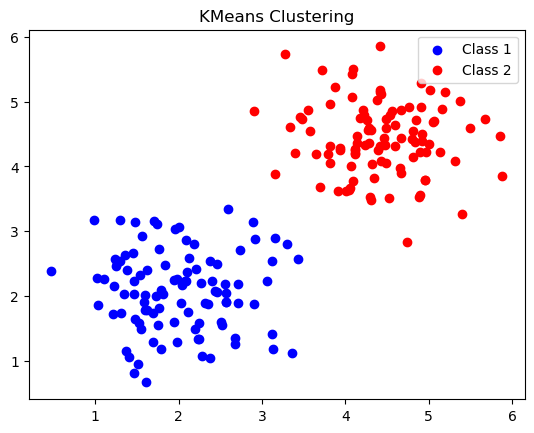

In [45]:
kmeans_clust1 = kmeans_clusters[0]
kmeans_clust2 = kmeans_clusters[1]

plt.scatter(kmeans_clust1[:, 0], kmeans_clust1[:, 1], color='blue', label='Class 1')
plt.scatter(kmeans_clust2[:, 0], kmeans_clust2[:, 1], color='red', label='Class 2')

plt.legend()
plt.title('KMeans Clustering')
plt.show()

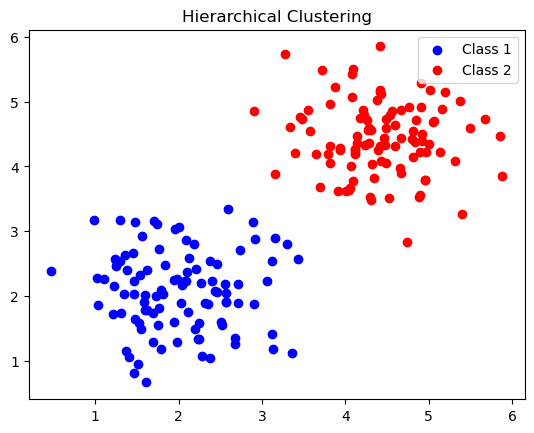

In [46]:
hier_clust1 = hier_clusters[0]
hier_clust2 = hier_clusters[1]

plt.scatter(hier_clust1[:, 0], hier_clust1[:, 1], color='blue', label='Class 1')
plt.scatter(hier_clust2[:, 0], hier_clust2[:, 1], color='red', label='Class 2')

plt.legend()
plt.title('Hierarchical Clustering')
plt.show()

# Question 4

In [185]:
X = genfromtxt('coding_final_data/parental_anxiety_vs_kids_age.csv', delimiter=',')

### 1)

In [186]:

sd = 0.3
def px(x):
    x = np.atleast_1d(x)
    pdf = np.sum(norm.pdf(x[:, None], X, sd), axis=1)

    pdf = pdf/len(X)
    return pdf

### 2)

In [ ]:

def estimate_q(X, degree=2, num_samples=500):
    samples_x = np.random.choice(X, num_samples, replace=False)
    y_values = px(samples_x)

    samples_x = samples_x.reshape(-1, 1)
    y_values = y_values.reshape(-1, 1)


    poly = PolynomialFeatures(degree)
    phi = poly.fit_transform(samples_x)

    scaler = StandardScaler()
    # phi[:, 1:] = scaler.fit_transform(phi[:, 1:])

    w = np.linalg.inv(phi.T.dot(phi)).dot(phi.T).dot(y_values)

    return w, scaler, poly


In [147]:
n = 4
w, scaler, poly = estimate_q(X, n)

def q(x):
    x = x.reshape(-1, 1)
    phi = poly.transform(x)
    # phi[:, 1:] = scaler.transform(phi[:, 1:])

    return phi @ w


### 3)

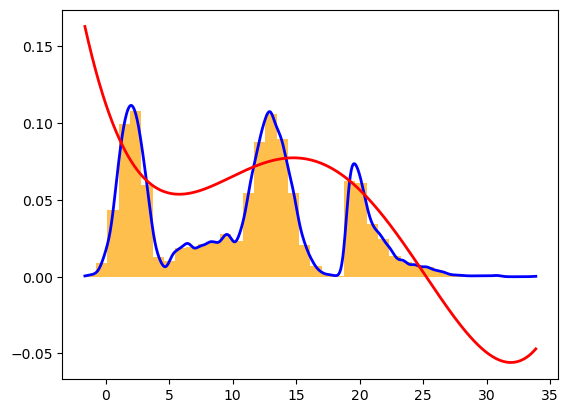

In [148]:
x = np.linspace(min(X), max(X), 1000)
kde_y = px(x)
q_y = q(x)

plt.hist(X, 40, facecolor='orange', alpha=0.7, density=True)
plt.plot(x, kde_y, color='blue', linewidth=2)
plt.plot(x, q_y, color='red', linewidth=2)
plt.show()

# Question 5

In [173]:
def KL_divergence(x, p2): 
    p_1 = px(x) 
    p_2 = p2(x)

    return p_1*np.log(p_1/p_2)

def KL_divergence_sample(x, q): 
    p_1 = np.log(np.maximum(px(x), 1e-10))
    p_2 = np.log(np.maximum(q(x), 1e-10)) 

    return np.mean(np.log(p_1/p_2))

In [ ]:
samples = np.random.choice(X, 200, replace=False)
samples_2d = samples.reshape(-1, 1)

kde = KernelDensity(kernel='gaussian', bandwidth=0.3).fit(samples_2d)
# samples_est = np.exp(kde.score_samples(samples_2d))

def q(x):
    if isinstance(x, float):
        x = np.array([[x]])
    else:
        x = x.reshape(-1, 1)
    return np.exp(kde.score_samples(x))


integration_kl, error = quad(KL_divergence, min(samples), max(samples), args=(q,))
print(integration_kl)

print(KL_divergence_sample(samples, q))

0.053326791759201575
0.03476940381984917


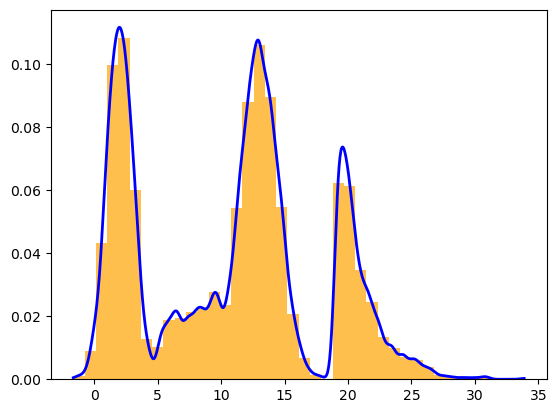

In [ ]:
X_2d = X.reshape(-1, 1)
kde = KernelDensity(kernel='gaussian', bandwidth=0.3).fit(X_2d)


x = np.linspace(min(X), max(X), 1000)
y = np.exp(kde.score_samples(x.reshape(-1, 1)))
plt.hist(X, 40, facecolor='orange', alpha=0.7, density=True)
plt.plot(x, y, color='blue', linewidth=2)
plt.show()

In [179]:
def KL_divergence(x, p2): 
    p_1 = px(x) 
    p_2 = p2(x)

    return p_1*np.log(p_1/p_2)

def KL_divergence_sample(x, q): 
    p_1 = np.log(np.maximum(px(x), 1e-10))
    p_2 = np.log(np.maximum(q(x), 1e-10)) 

    return np.mean(np.log(p_1/p_2))

# from scipy.integrate import quad 
# samples = np.random.choice(X, 200, replace=False)


# kde = KernelDensity(kernel='gaussian', bandwidth=0.3).fit(samples_2d)
# samples_est = np.exp(kde.score_samples(samples_2d))




# integration_kl, error = quad(KL_divergence, min(samples), max(samples), args=(q,))
# print(integration_kl)

# print(KL_divergence_sample(samples, q))


def kl_div_func(samples):
    samples_2d = samples.reshape(-1, 1)

    kde = KernelDensity(kernel='gaussian', bandwidth=0.3).fit(samples_2d)

    def q(x):
        if isinstance(x, float):
            x = np.array([[x]])
        else:
            x = x.reshape(-1, 1)
        return np.exp(kde.score_samples(x))

    integration_kl, error = quad(KL_divergence, min(samples), max(samples), args=(q,))
    sampling_kl = KL_divergence_sample(samples, q)

    return integration_kl, sampling_kl


In [180]:
import numpy as np

total_samples = len(X)
batch_size = 200

# Initialize
remaining_indices = np.arange(total_samples)
selected_indices = np.array([], dtype=int)  

integration_kl_list = []
sampling_kl_list = []
sample_size_list = []

while len(remaining_indices) > 0:
    n = min(batch_size, len(remaining_indices))
    
    new_indices = np.random.choice(remaining_indices, size=n, replace=False)
    
    selected_indices = np.concatenate([selected_indices, new_indices])
    remaining_indices = np.setdiff1d(remaining_indices, new_indices)
    
    current_samples = X[selected_indices]

    integration_kl, sampling_kl = kl_div_func(current_samples)

    integration_kl_list.append(integration_kl)
    sampling_kl_list.append(sampling_kl)
    sample_size_list.append(len(current_samples))
  

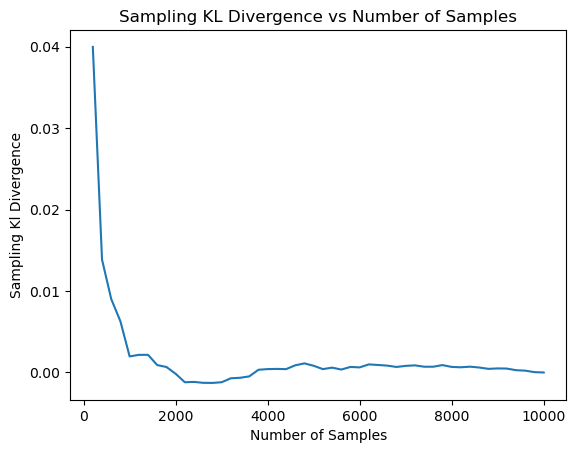

In [183]:
plt.plot(sample_size_list, sampling_kl_list)
plt.xlabel('Number of Samples')
plt.ylabel('Sampling Kl Divergence')
plt.title('Sampling KL Divergence vs Number of Samples')
plt.show()

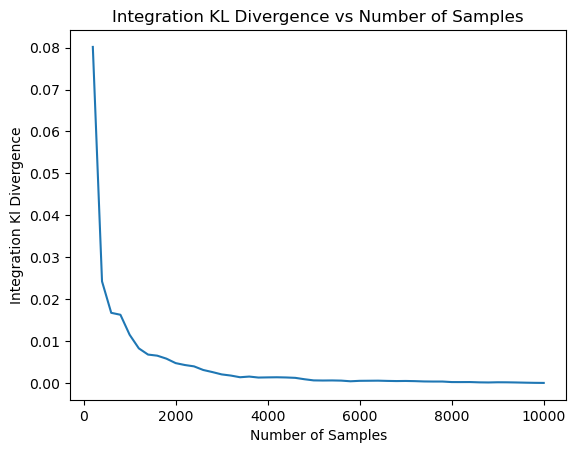

In [184]:
plt.plot(sample_size_list, integration_kl_list)
plt.xlabel('Number of Samples')
plt.ylabel('Integration Kl Divergence')
plt.title('Integration KL Divergence vs Number of Samples')
plt.show()

Based off the graphs, around 2000 samples is a good cutoff point to approximate p(x)

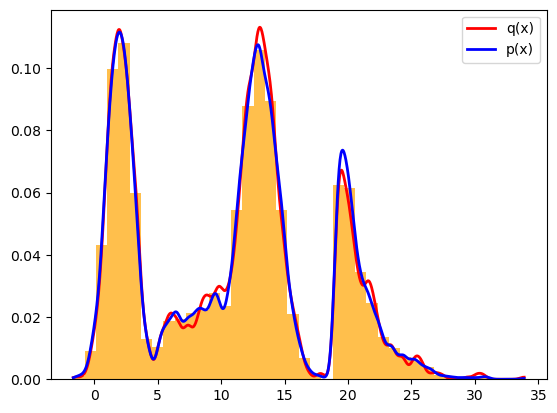

In [190]:
q_samples = np.random.choice(X, size=2000, replace=False)

kde = KernelDensity(kernel='gaussian', bandwidth=0.3).fit(q_samples.reshape(-1, 1))


x = np.linspace(min(X), max(X), 1000)
px_y = px(x)
q_y = np.exp(kde.score_samples(x.reshape(-1, 1)))
plt.hist(X, 40, facecolor='orange', alpha=0.7, density=True)
plt.plot(x, q_y, color='red', linewidth=2, label='q(x)')
plt.plot(x, px_y, color='blue', linewidth=2, label='p(x)')
plt.legend()
plt.show()

This approach was much better than trying to fit p(x) with regression, as q(x) is a much better estimate for p(x).

# Question 6

In [295]:
X = genfromtxt('coding_final_data/Pollution_data.csv', delimiter=',')

### 1)

In [296]:
def center_func(n):
      C = np.eye(n) - (1/n) * np.ones((n, n))
      return C

def cov_matrix_func(X, C):
     Q = X.T @ C @ X
     return Q
     

def pca_reduc_func(X, num_dimensions):
    n = len(X)

    C = center_func(n)
    Q = cov_matrix_func(X, C)

    [D, V] = np.linalg.eigh(Q)

    v = V[:, -num_dimensions:]

    X_hat = X @ v 

    return X_hat, v, D 

In [297]:
X_hat, v, D = pca_reduc_func(X, 2)

In [298]:
print(f'Eigenvalues: {D}')

Eigenvalues: [2.69642389e-04 2.73159907e-04 2.75267308e-04 2.80417659e-04
 2.85707467e-04 2.86341978e-04 2.89345358e-04 2.93905147e-04
 2.96249483e-04 2.98356797e-04 2.99677476e-04 3.03046564e-04
 3.05465210e-04 3.07014295e-04 3.08375208e-04 3.12026289e-04
 3.16510763e-04 3.17235118e-04 3.19342811e-04 3.22876701e-04
 3.25893845e-04 3.26788262e-04 3.27890496e-04 3.29542661e-04
 3.30373642e-04 3.33750407e-04 3.37606004e-04 3.40201083e-04
 3.41820829e-04 3.43244102e-04 3.46014088e-04 3.48740626e-04
 3.50739217e-04 3.54574282e-04 3.56026285e-04 3.59274670e-04
 3.62416164e-04 3.64127146e-04 3.65199020e-04 3.69155041e-04
 3.72395404e-04 3.77610710e-04 3.78219560e-04 3.80162477e-04
 3.81842312e-04 3.89702150e-04 3.94337127e-04 4.03801662e-04
 7.56036526e+03 5.79500609e+06]


Based on the eigenvalues, the data should be reduced to two dimensions as there are two eigenvalues much larger than the others

### 2)

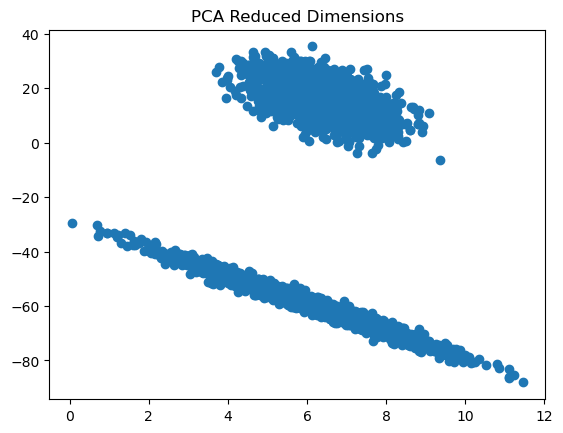

In [299]:
plt.scatter(X_hat[:, 0], X_hat[:, 1])
plt.title('PCA Reduced Dimensions')
plt.show()

The data seems to split up into two groups, a more circular cluster at the top and then a linear cluster, with a negative slope. There definitely is a pattern that separates the two groups but at this time it is unknown which group is which.

### 3)

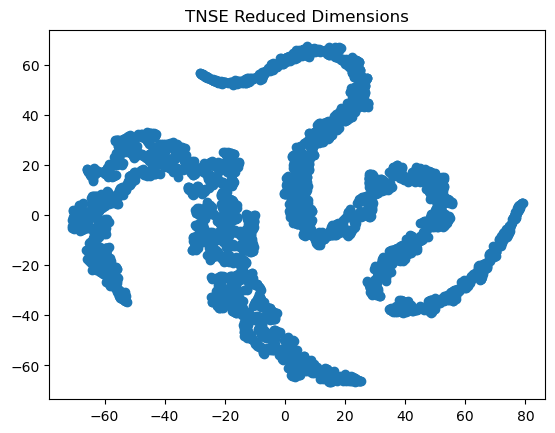

In [ ]:
X_embedded = TSNE(n_components=2).fit_transform(X)

plt.scatter(X_embedded[:, 0], X_embedded[:, 1])
plt.title('TNSE Reduced Dimensions')
plt.show()

### 4)

TNSE finds similarity between two points in higher dimensional space and uses a probability distribution to assign probabilities to the pairs. Then dimensions are reduced by trying to keep similarity between pairs. However, the PCA-reduced data is more appropriate to calcuate the covariance matrices because PCA maximizes variance via the covariance matrix and then computes the eigenvalues and vectors of that matrix. 

In [216]:
# Using PCA graph, y-values of one cluster are below -20, so split groups based off this
group0 = X_hat[X_hat[:, 1] > -20]
group1 = X_hat[X_hat[:, 1] <= -20]

C0 = center_func(len(group0))
C1 = center_func(len(group1))

group0_cov = cov_matrix_func(group0, C0)
group1_cov = cov_matrix_func(group1, C1)

print(f'Group 0 Norm: {np.linalg.norm(group0, ord="fro")}')
print(f'Group 1 Norm: {np.linalg.norm(group1, ord="fro")}')

Group 0 Norm: 812.9735927817039
Group 1 Norm: 2671.1871859148914


Group 1 (y values less than -20) has a much higher norm, so they are the kids that are impacted. Create labels where 0 is not impacted and 1 is impacted.

In [224]:
y_values = np.where(X_hat[:, 1] > -20, 0, 1).reshape(-1, 1)

### 5)

In [226]:
from sklearn.model_selection import train_test_split

X_train, X_rest, y_train, y_rest = train_test_split(X_hat, y_values, test_size=0.2)
X_test, X_val, y_test, y_val = train_test_split(X_rest, y_rest, test_size=0.5)

# Scale data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [227]:
def accuracy_func(predictions, y):
    return np.mean(predictions == y)

# Logistic Regression
def f_prime(w, phi, y):
    return 1/len(phi) * phi.T @ (sigmoid(phi, w) - y)

def sigmoid(phi, w):
    return 1/(1 + np.exp(-phi @ w))

def gradient_descent(phi, y, w, eta, num_iterations):
	for i in range(num_iterations):
		w = w - eta * f_prime(w, phi, y)  
            
	return w

def log_reg_pred(phi, w):
      return np.where(sigmoid(phi, w) >= 0.5, 1, 0)

In [233]:
phi = np.hstack((np.ones((X_train.shape[0], 1)), X_train))

w0 = np.zeros((phi.shape[1], 1))
eta = 0.002

w = gradient_descent(phi, y_train, w0, eta, 10000)

# Accuracy using test
phi_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))
predictions = log_reg_pred(phi_test, w)
acc = accuracy_func(predictions, y_test)
print(f'Test Accuracy: {acc}')

Test Accuracy: 1.0


### 6)

In [251]:
# SVM algorithm
def lagrange_prime(X, w, y):
    return 2*w - X.T.dot(y)  # SVM deriv

def gradient_descent(X, y, w, eta, num_iterations):
	for i in range(num_iterations):
		w = w - eta * lagrange_prime(X, w, y)
            
	return w

def get_svm_params(w, X, y, eta, num_iterations):
	svm_y = y.copy()  # don't change y_train

	svm_y[svm_y == 0] = -1

	svm_w = gradient_descent(X, svm_y, w, eta, num_iterations)  # find w

	w_hat = (svm_w/np.linalg.norm(svm_w))

	X_neg = X[svm_y == -1]
	X_pos = X[svm_y == 1]

	# Support vectors are max of the negatives and min of the positives
	neg_support = np.max(X_neg.dot(w_hat))
	pos_support = np.min(X_pos.dot(w_hat))

	# b is midpoint of support vectors
	b = (pos_support + neg_support)/2

	return b, w_hat

In [253]:
w0 = np.ones(X_train.shape[1])
svm_y = y_train.flatten().copy()  # don't change y_train
svm_y[svm_y == 0] = -1

eta = 0.0001
num_iterations = 10000

# Get b and w
svm_b, svm_w_hat = get_svm_params(w0, X_train, svm_y, eta, num_iterations)

def svm(X):
	return np.sign(X.dot(svm_w_hat) - svm_b)

# Find predictions
# predictions = svm(X_train)
test_predictions = svm(X_test)

test_svm_y = y_test.flatten().copy() 
test_svm_y[test_svm_y == 0] = -1

# Accuracy
# accuracy = accuracy_func(predictions, svm_y)
test_accuracy = accuracy_func(test_predictions, test_svm_y)
# print(f"Accuracy of SVM (train): {accuracy:.2f}")
print(f"Accuracy of SVM (test): {test_accuracy:.2f}")

Accuracy of SVM (test): 1.00


Both models had an accuracy of 100%.

### 7)

In [317]:
# K-Means Algo
def random_row(matrix, n):
    idx = np.random.choice(len(matrix)-1, size=n, replace=False)

    return matrix[idx,:]

def make_clusters(matrix, centers):
    dists = np.linalg.norm(matrix[:, np.newaxis, :] - centers[np.newaxis, :, :], axis=2)
    clusters_dict = defaultdict(list)

    for i, dist in enumerate(dists):
        cluster_idx = np.argsort(dist)[0]

        clusters_dict[cluster_idx].append(matrix[i, :])

    for i in range(len(clusters_dict.keys())):
        clusters_dict[i] = np.vstack(clusters_dict[i])

    return clusters_dict

def find_centers(clusters_dict):
    centers = []

    for matrix in clusters_dict.values():
        clust_center = np.mean(matrix, axis=0)
        centers.append(clust_center)

    centers = np.vstack(centers)
    return centers

def kmeans_alg(X, num_clusters):
    centers = random_row(X, num_clusters)
    prev_centers = centers.copy()

    while True:
        clusters_dict = make_clusters(X, centers)
        centers = find_centers(clusters_dict)

        if np.allclose(centers, prev_centers):
            break

        prev_centers = centers.copy()


    return clusters_dict

def predict_labels(X, y, cluster_dict):
    predict_labels = [0] * len(cluster_dict[0]) + [1] * len(cluster_dict[1])
    real_labels = []

    for cluster_idx, cluster_points in cluster_dict.items():
        
        for point in cluster_points:
            # Find the index of the point in X
            idx = np.where(np.all(X == point, axis=1))[0][0]
            real_labels.append(int(y[idx]))

    return predict_labels, real_labels

In [318]:
kmeans_clusts = kmeans_alg(X_hat, 2)

In [323]:
kmeans_predict_labels, kmeans_real_labels = predict_labels(X_hat, y_values.flatten(), kmeans_clusts)

print(f'KMeans Normalized Mutual Information: {normalized_mutual_info_score(kmeans_real_labels, kmeans_predict_labels):.3f}')

KMeans Normalized Mutual Information: 1.000
